In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# encoding
from sklearn.preprocessing import LabelEncoder

# 데이터 split
from sklearn.model_selection import train_test_split

# 사용 모델
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor

# 파라미터 조정
from sklearn.model_selection import GridSearchCV

# 평가
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 모델 저장
import joblib


## 데이터 확인

In [39]:
df = pd.read_csv('preprocessed_SeriesOn.csv')
df.columns

Index(['title', 'year', 'version', 'type', 'director', 'actor', 'age',
       'runtime', 'rating', 'like', 'comment', 'isDRM', 'cost', 'period',
       'is_action', 'is_comedy', 'is_drama', 'is_melo', 'is_horror',
       'is_fantasy', 'is_animation', 'is_DQ', 'is_indie', 'is_concert'],
      dtype='object')

In [40]:
df.drop(['title', 'comment'], axis=1, inplace=True)
df.replace('Null', None, inplace=True)
df['isDRM'].replace('DRM', 1, inplace=True)
df['isDRM'].replace('DRM_free', 0, inplace=True)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29185 entries, 0 to 29184
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         29185 non-null  object 
 1   year          29185 non-null  int64  
 2   version       2785 non-null   object 
 3   type          29185 non-null  object 
 4   director      29143 non-null  object 
 5   actor         27503 non-null  object 
 6   age           29185 non-null  object 
 7   runtime       29185 non-null  int64  
 8   rating        29185 non-null  float64
 9   like          29185 non-null  int64  
 10  comment       29185 non-null  int64  
 11  isDRM         29185 non-null  int64  
 12  cost          29185 non-null  int64  
 13  period        29185 non-null  object 
 14  is_action     29185 non-null  int64  
 15  is_comedy     29185 non-null  int64  
 16  is_drama      29185 non-null  int64  
 17  is_melo       29185 non-null  int64  
 18  is_horror     29185 non-nu

In [15]:
df.head()

,title,year,version,type,director,actor,age,runtime,rating,like,...,is_action,is_comedy,is_drama,is_melo,is_horror,is_fantasy,is_animation,is_DQ,is_indie,is_concert
0,'개그' 더 크라운,2021,None,구매,아담 크라우스,"로렌 애슐리 카터,트레이시 페레즈",15세 관람가,89,6.33,0,...,0,1,0,0,1,0,0,0,0,0
1,'데이빗 린치' 단편선,0,None,구매,데이빗 린치,None,19세 관람가,148,10.00,21,...,0,0,1,0,0,0,0,0,0,0
2,...ing,2003,None,구매,이언희,"임수정,김래원,이미숙,최덕문,이성경,김지영,윤덕현,이유정",12세 관람가,103,8.89,9,...,0,0,0,1,0,0,0,0,0,0
3,...ing,2003,None,대여,이언희,"임수정,김래원,이미숙,최덕문,이성경,김지영,윤덕현,이유정",12세 관람가,103,8.89,4,...,0,0,0,1,0,0,0,0,0,0
4,0,0,None,구매,이보리,"박현수,이보리,전혜원,이민지,공예림",15세 관람가,18,10.00,1,...,0,0,1,0,0,0,0,0,0,0


## 인코딩

In [41]:
# 범주형 데이터를 one-hot encoding으로 변환
df_encoded = df.copy()

# LabelEncoder 객체 생성
label_encoder = LabelEncoder()

# 제목(title)을 인코딩
# df_encoded['title'] = label_encoder.fit_transform(df['title'])

# 더빙/자막(version)을 인코딩
df_encoded['version'] = label_encoder.fit_transform(df['version'])

# 대여/구매/무료(type)를 인코딩
df_encoded['type'] = label_encoder.fit_transform(df['type'])

# 감독(director)을 인코딩
df_encoded['director'] = label_encoder.fit_transform(df['director'])

# 배우(actor)를 인코딩
df_encoded['actor'] = label_encoder.fit_transform(df['actor'])

# 연령제한(age)을 인코딩
df_encoded['age'] = label_encoder.fit_transform(df['age'])

# 대여기간(period)을 인코딩
df_encoded['period'] = label_encoder.fit_transform(df['period'])

In [42]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29185 entries, 0 to 29184
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          29185 non-null  int64  
 1   version       29185 non-null  int64  
 2   type          29185 non-null  int64  
 3   director      29185 non-null  int64  
 4   actor         29185 non-null  int64  
 5   age           29185 non-null  int64  
 6   runtime       29185 non-null  int64  
 7   rating        29185 non-null  float64
 8   like          29185 non-null  int64  
 9   isDRM         29185 non-null  int64  
 10  cost          29185 non-null  int64  
 11  period        29185 non-null  int64  
 12  is_action     29185 non-null  int64  
 13  is_comedy     29185 non-null  int64  
 14  is_drama      29185 non-null  int64  
 15  is_melo       29185 non-null  int64  
 16  is_horror     29185 non-null  int64  
 17  is_fantasy    29185 non-null  int64  
 18  is_animation  29185 non-nu

In [43]:
x = df_encoded.drop('rating', axis=1)
y = df_encoded['rating']

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)

## 모델 학습

### 1. XGBoost

In [ ]:
# XGBoost 모델 학습 및 예측
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(x_train, y_train)
y_pred_xgb = xgb_model.predict(x_test)

In [ ]:
# 여러 평가 지표 계산
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

# 결과 출력
print(f'Mean Squared Error (MSE): {mse_xgb:.4f}')
print(f'Mean Absolute Error (MAE): {mae_xgb:.4f}')
print(f'R² Score: {r2_xgb:.4f}')

score_xgb = [mse_xgb, mae_xgb, r2_xgb]

Mean Squared Error (MSE): 4.7039
Mean Absolute Error (MAE): 1.5184
R² Score: 0.5650


### 2. LightGBM

In [ ]:
# 모델 학습 및 예측
lgb_model = lgb.LGBMRegressor(random_state=42)
lgb_model.fit(x_train, y_train)
y_pred_lgb = lgb_model.predict(x_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004988 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 865
[LightGBM] [Info] Number of data points in the train set: 23348, number of used features: 19
[LightGBM] [Info] Start training from score 5.744589


In [ ]:
# 여러 평가 지표 계산
mse_lgb = mean_squared_error(y_test, y_pred_lgb)
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)
r2_lgb = r2_score(y_test, y_pred_lgb)

# 결과 출력
print(f'Mean Squared Error (MSE): {mse_lgb:.4f}')
print(f'Mean Absolute Error (MAE): {mae_lgb:.4f}')
print(f'R² Score: {r2_lgb:.4f}')

score_lgb = [mse_lgb, mae_lgb, r2_lgb]

Mean Squared Error (MSE): 5.2886
Mean Absolute Error (MAE): 1.6606
R² Score: 0.5110


### 3. Random Forest

In [ ]:
# 랜덤 포레스트 모델 생성 및 훈련
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(x_train, y_train)

# 테스트 데이터로 예측
y_pred_rf = rf_regressor.predict(x_test)

In [ ]:
# 여러 평가 지표 계산
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# 결과 출력
print(f'Mean Squared Error (MSE): {mse_rf:.4f}')
print(f'Mean Absolute Error (MAE): {mae_rf:.4f}')
print(f'R² Score: {r2_rf:.4f}')

score_rf = [mse_rf, mae_rf, r2_rf]

Mean Squared Error (MSE): 4.6902
Mean Absolute Error (MAE): 1.4487
R² Score: 0.5663


## 평가 지표 확인

In [ ]:
score_df = pd.DataFrame(data=[score_xgb, score_lgb, score_rf], index=['xgb', 'lgb', 'rf'], columns=['mse', 'mae', 'r2'])
score_df

,mse,mae,r2
xgb,5.091385,1.599611,0.529216
lgb,5.288633,1.660579,0.510978
rf,4.690183,1.448657,0.566314


## 파라미터 조정 및 재학습

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],  # 결정 트리 개수
    'max_depth': [None, 10, 20, 30],  # 트리의 최대 깊이
    'min_samples_split': [2, 5, 10],  # 내부 노드를 분할하는 최소 샘플 수
    'min_samples_leaf': [1, 2, 4]  # 리프 노드에 필요한 최소 샘플 수
}

grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error', verbose=1)

In [ ]:
# 최적의 파라미터
print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [ ]:
# 테스트 데이터로 모델 평가
y_pred_be = grid_search.best_estimator_.predict(x_test)
mse_be = mean_squared_error(y_test, y_pred_be)
mae_be = mean_absolute_error(y_test, y_pred_be)
r2_be = r2_score(y_test, y_pred_be)

print("\nTest set evaluation:")
print("MSE: {:.4f}".format(mse_be))
print("MAE: {:.4f}".format(mae_be))
print("R² Score: {:.4f}".format(r2_be))


Test set evaluation:
MSE: 4.6582
MAE: 1.4458
R² Score: 0.5693


## 모델 저장

In [ ]:
# 최적의 모델 저장
joblib_file = "best_ridge_model.pkl"
joblib.dump(grid_search.best_estimator_, joblib_file)

['best_ridge_model.pkl']

In [ ]:
# 파일 다운로드
from google.colab import files
files.download('best_ridge_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 모델 재학습 및 평가

In [44]:
# 모델 생성 및 훈련
rf_regressor = RandomForestRegressor(random_state=42, max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=300)
rf_regressor.fit(x_train, y_train)

# 테스트 데이터로 예측
y_pred_rf = rf_regressor.predict(x_test)

In [45]:
# 여러 평가 지표 계산
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# 결과 출력
print(f'Mean Squared Error (MSE): {mse_rf:.4f}')
print(f'Mean Absolute Error (MAE): {mae_rf:.4f}')
print(f'R² Score: {r2_rf:.4f}')

Mean Squared Error (MSE): 4.5967
Mean Absolute Error (MAE): 1.4818
R² Score: 0.5750


## 피처 중요도 추출

In [46]:
# 피처 중요도 추출
feature_importances = rf_regressor.feature_importances_

# 피처 중요도를 데이터프레임으로 변환
feature_importances_df = pd.DataFrame({
    'feature': x.columns,
    'importance': feature_importances
})

# 중요도 순으로 정렬
feature_importances_df = feature_importances_df.sort_values(by='importance', ascending=False)

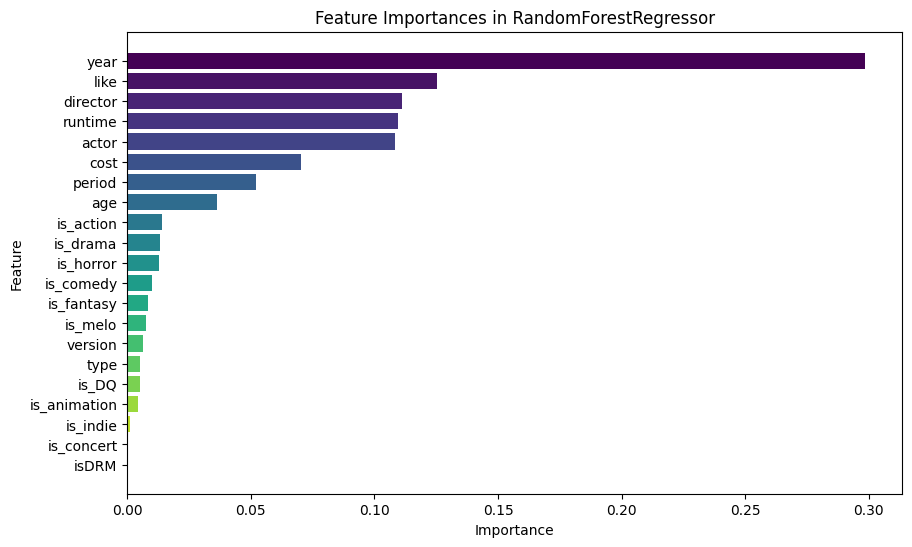

In [57]:
# 색상 설정
colors = plt.cm.viridis(np.linspace(0, 1, len(feature_importances_df)))

# 피처 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df['feature'], feature_importances_df['importance'], color=colors)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in RandomForestRegressor')
plt.gca().invert_yaxis()
plt.show()